In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.preprocessing import LabelEncoder
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
# Load dataset
df = pd.read_excel("P556.xlsx")
print(df.shape)
df.head()

(1440, 3)


,title,rating,body
0,Horrible product,1,Very disappointed with the overall performance...
1,Camera quality is not like 48 megapixel,3,Camera quality is low
2,Overall,4,"Got the mobile on the launch date,Battery must..."
3,A big no from me,1,1. It doesn't work with 5.0GHz WiFi frequency....
4,Put your money somewhere else,1,"Not worth buying....faulty software, poor disp..."


In [3]:
print(df.isnull().sum())


title     0
rating    0
body      0
dtype: int64


In [4]:
print("\nColumn Names:", df.columns.tolist())


Column Names: ['title', 'rating', 'body']


In [5]:
print("\nDataset Info:\n")
df.info()


Dataset Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   1440 non-null   object
 1   rating  1440 non-null   int64 
 2   body    1440 non-null   object
dtypes: int64(1), object(2)
memory usage: 33.9+ KB


In [6]:
print("\nDescriptive Stats for Numeric Columns:\n", df.describe())


Descriptive Stats for Numeric Columns:
             rating
count  1440.000000
mean      3.173611
std       1.584453
min       1.000000
25%       1.000000
50%       4.000000
75%       5.000000
max       5.000000


In [7]:
print("\nNumber of Duplicates:", df.duplicated().sum())
df = df.drop_duplicates()


Number of Duplicates: 0


In [8]:
for col in df.columns:
    print(f"\nUnique values in '{col}': {df[col].nunique()}")


Unique values in 'title': 1351

Unique values in 'rating': 5

Unique values in 'body': 1440


In [9]:
# Combine title and body for full review text
df['text'] = df['title'].astype(str) + ' ' + df['body'].astype(str)
df = df[['text', 'rating']]  # Keep relevant columns

In [10]:
df.head()

,text,rating
0,Horrible product Very disappointed with the ov...,1
1,Camera quality is not like 48 megapixel Camera...,3
2,"Overall Got the mobile on the launch date,Batt...",4
3,A big no from me 1. It doesn't work with 5.0GH...,1
4,Put your money somewhere else Not worth buying...,1


In [11]:
# Rating: 4-5 -> Positive, 3 -> Neutral, 1-2 -> Negative
df['sentiment'] = df['rating'].apply(lambda x: 'positive' if x >= 4 else 'negative' if x <= 2 else 'neutral')
df[['rating', 'sentiment']].head()

,rating,sentiment
0,1,negative
1,3,neutral
2,4,positive
3,1,negative
4,1,negative


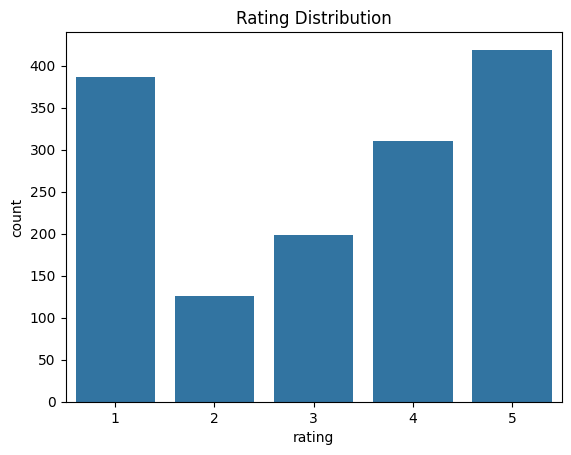

In [12]:
# Rating distribution
sns.countplot(x='rating', data=df)
plt.title("Rating Distribution")
plt.show()

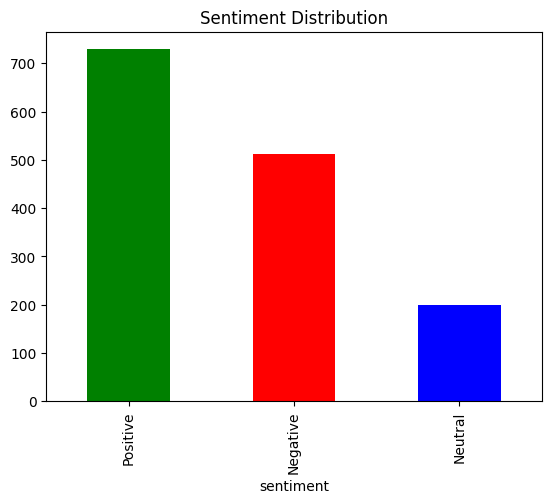

In [13]:
# Simplify sentiment (Positive: 4-5, Neutral: 3, Negative: 1-2)
def label_sentiment(rating):
    if rating >= 4:
        return "Positive"
    elif rating == 3:
        return "Neutral"
    else:
        return "Negative"

df['sentiment'] = df['rating'].apply(label_sentiment)
df['sentiment'].value_counts().plot(kind='bar', color=['green', 'red', 'blue'])
plt.title("Sentiment Distribution")
plt.show()

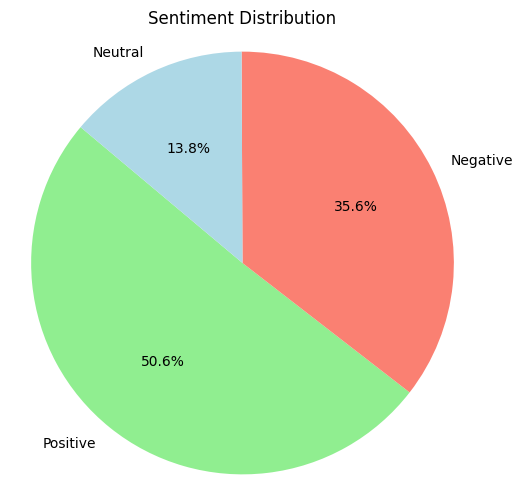

In [14]:
sentiment_counts = df['sentiment'].value_counts()
labels = sentiment_counts.index
sizes = sentiment_counts.values

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=['lightgreen', 'salmon', 'lightblue'])
plt.title('Sentiment Distribution')
plt.axis('equal')
plt.show()

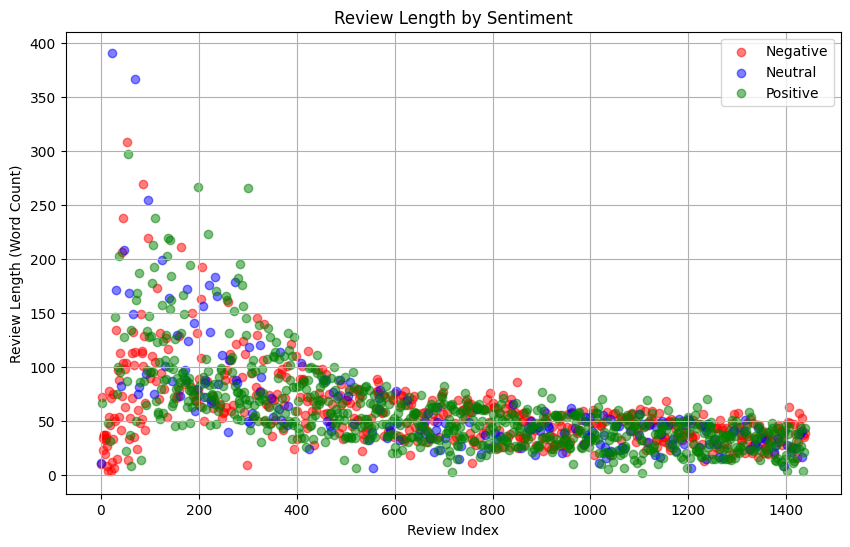

In [15]:
plt.figure(figsize=(10, 6))
colors = {'positive': 'green', 'negative': 'red', 'neutral': 'blue'}

for sentiment in df['sentiment'].unique():
    normalized_sentiment = str(sentiment).strip().lower()
    subset = df[df['sentiment'].str.strip().str.lower() == normalized_sentiment]
    review_lengths = subset['text'].apply(lambda x: len(str(x).split()))
    plt.scatter(
        subset.index,
        review_lengths,
        label=normalized_sentiment.capitalize(),
        alpha=0.5,
        color=colors.get(normalized_sentiment, 'gray')
    )

plt.title("Review Length by Sentiment")
plt.xlabel("Review Index")
plt.ylabel("Review Length (Word Count)")
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipython-input-16-3868439319.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_temp, x='sentiment', y='review_length', palette='Set2')


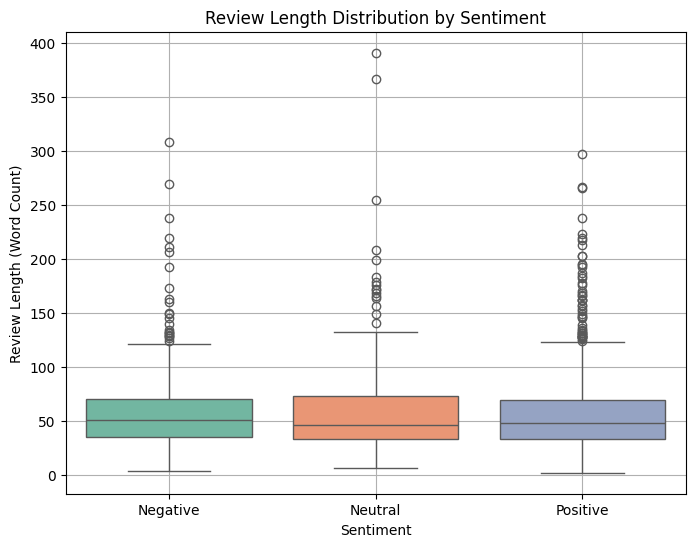

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Inline computation of review lengths from 'cleaned_review'
df_temp = df[['sentiment', 'text']].copy()
df_temp['review_length'] = df_temp['text'].apply(lambda x: len(str(x).split()) if pd.notnull(x) else 0)

# Plot boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_temp, x='sentiment', y='review_length', palette='Set2')
plt.title('Review Length Distribution by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Review Length (Word Count)')
plt.grid(True)
plt.show()

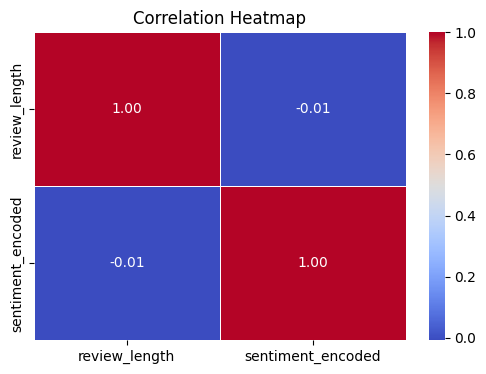

In [17]:

# Calculate review length and add to df
df['review_length'] = df['text'].apply(lambda x: len(str(x).split()) if pd.notnull(x) else 0)

# Encode the 'sentiment' column
le = LabelEncoder()
df['sentiment_encoded'] = le.fit_transform(df['sentiment'])

# Select only numeric columns
numeric_df = df[['review_length', 'sentiment_encoded']]

# Compute correlation
corr = numeric_df.corr()

# Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [18]:
def preprocess(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)  # remove links
    text = re.sub(r'<.*?>', '', text)    # remove HTML
    text = re.sub(r'[^a-zA-Z]', ' ', text)  # keep only letters
    text = ''.join([c for c in text if c not in string.punctuation])
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [stemmer.stem(word) for word in tokens]
    return ' '.join(tokens)

df['clean_text'] = df['text'].apply(preprocess)

In [19]:
df.head()

,text,rating,sentiment,review_length,sentiment_encoded,clean_text
0,Horrible product Very disappointed with the ov...,1,Negative,10,0,horribl product disappoint overal perform samsung
1,Camera quality is not like 48 megapixel Camera...,3,Neutral,11,1,camera qualiti like megapixel camera qualiti low
2,"Overall Got the mobile on the launch date,Batt...",4,Positive,67,2,overal got mobil launch date batteri must appr...
3,A big no from me 1. It doesn't work with 5.0GH...,1,Negative,72,0,big work ghz wifi frequenc ghz old school came...
4,Put your money somewhere else Not worth buying...,1,Negative,34,0,put money somewher els worth buy faulti softwa...


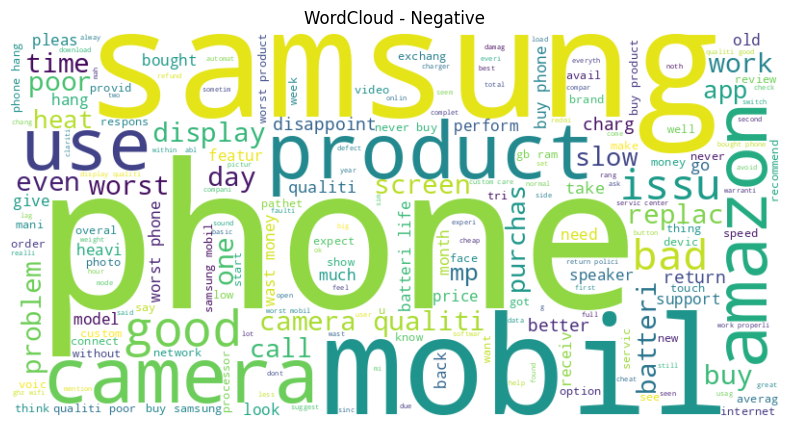

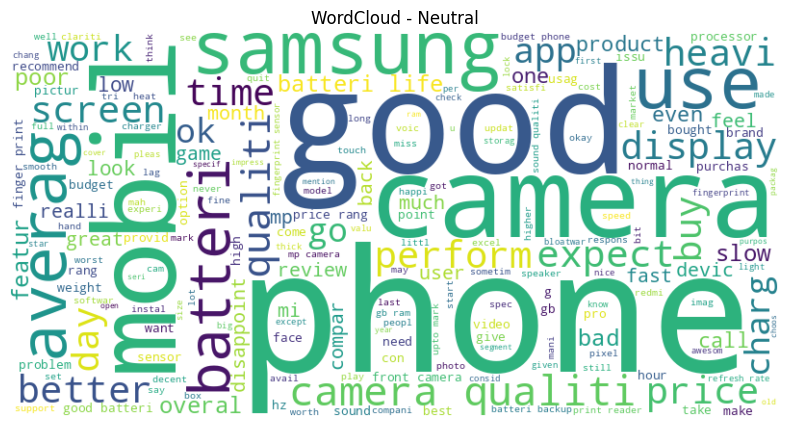

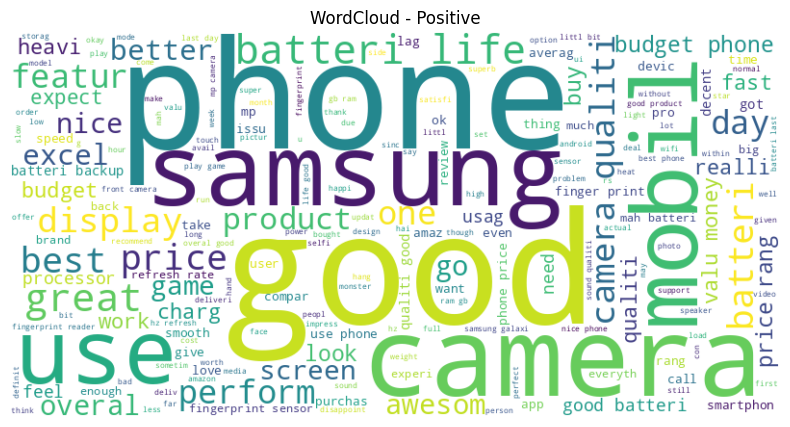

In [20]:
for sentiment in df['sentiment'].unique():
    text = ' '.join(df[df['sentiment'] == sentiment]['clean_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"WordCloud - {sentiment}")
    plt.show()

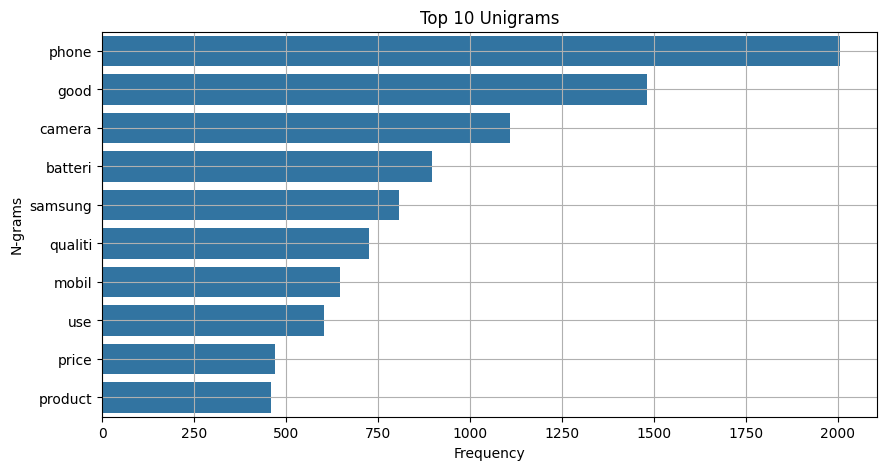

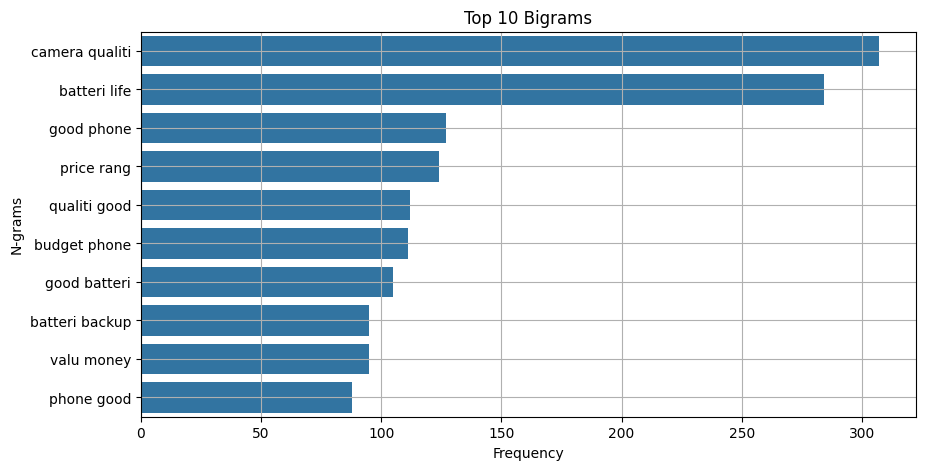

In [21]:
def plot_top_ngrams(corpus, ngram_range=(1,1), n=10, title='Top Words'):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english')
    X = vec.fit_transform(corpus)
    sum_words = X.sum(axis=0)

    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:n]

    words, counts = zip(*words_freq)

    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(counts), y=list(words))
    plt.title(title)
    plt.xlabel("Frequency")
    plt.ylabel("N-grams")
    plt.grid(True)
    plt.show()

# Unigrams
plot_top_ngrams(df['clean_text'], ngram_range=(1,1), n=10, title='Top 10 Unigrams')

# Bigrams
plot_top_ngrams(df['clean_text'], ngram_range=(2,2), n=10, title='Top 10 Bigrams')

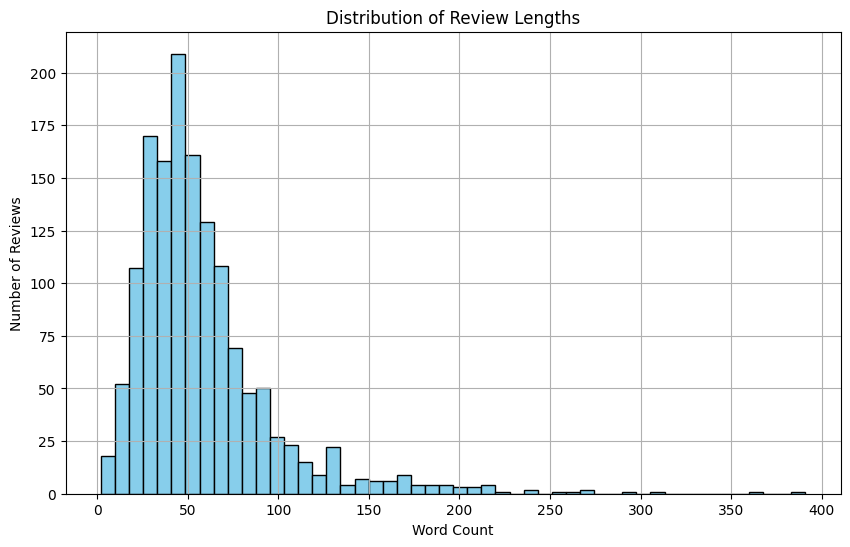

In [22]:
plt.figure(figsize=(10, 6))
plt.hist(df['review_length'], bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution of Review Lengths")
plt.xlabel("Word Count")
plt.ylabel("Number of Reviews")
plt.grid(True)
plt.show()

Class Distribution (%):
 sentiment
Positive    50.62
Negative    35.56
Neutral     13.82
Name: proportion, dtype: float64


/tmp/ipython-input-23-72385730.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='pastel')


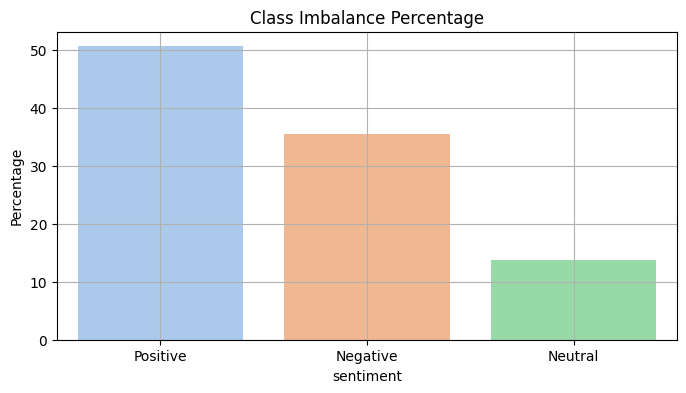

In [23]:
sentiment_counts = df['sentiment'].value_counts(normalize=True) * 100
print("Class Distribution (%):\n", sentiment_counts.round(2))

plt.figure(figsize=(8, 4))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='pastel')
plt.title("Class Imbalance Percentage")
plt.ylabel("Percentage")
plt.grid(True)
plt.show()

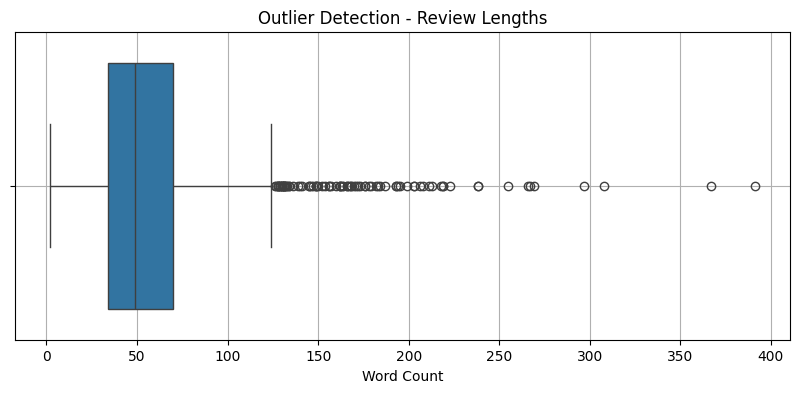


Number of Review Length Outliers: 88


In [24]:
# Boxplot to visually inspect outliers
plt.figure(figsize=(10, 4))
sns.boxplot(x=df['review_length'])
plt.title("Outlier Detection - Review Lengths")
plt.xlabel("Word Count")
plt.grid(True)
plt.show()

# Quantitative detection using IQR
Q1 = df['review_length'].quantile(0.25)
Q3 = df['review_length'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['review_length'] < lower_bound) | (df['review_length'] > upper_bound)]
print(f"\nNumber of Review Length Outliers: {outliers.shape[0]}")


In [25]:
##Model Building(NLP)-Model,Evaluation

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

models = {
    "Logistic Regression": LogisticRegression(),
    "Naive Bayes": MultinomialNB(),
    "SVM": LinearSVC(),
    "Random Forest": RandomForestClassifier()
}

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['clean_text'], df['sentiment_encoded'], test_size=0.2, random_state=42)

# Vectorize the text data
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [35]:
results = {}

for name, model in models.items():
    model.fit(X_train_vec, y_train)
    preds = model.predict(X_test_vec)

    print(f"--- {name} ---")
    print("Accuracy:", accuracy_score(y_test, preds))
    print("Classification Report:\n", classification_report(y_test, preds, target_names=le.classes_))
    print("Confusion Matrix:\n", confusion_matrix(y_test, preds))
    print("\n")

    results[name] = {
        "Accuracy": accuracy_score(y_test, preds),
        "Report": classification_report(y_test, preds, output_dict=True),
        "Confusion Matrix": confusion_matrix(y_test, preds)
    }

--- Logistic Regression ---
Accuracy: 0.7777777777777778
Classification Report:
               precision    recall  f1-score   support

    Negative       0.89      0.81      0.85       111
     Neutral       0.45      0.30      0.36        44
    Positive       0.77      0.91      0.83       133

    accuracy                           0.78       288
   macro avg       0.70      0.67      0.68       288
weighted avg       0.77      0.78      0.77       288

Confusion Matrix:
 [[ 90   8  13]
 [  7  13  24]
 [  4   8 121]]


--- Naive Bayes ---
Accuracy: 0.7638888888888888
Classification Report:
               precision    recall  f1-score   support

    Negative       0.90      0.79      0.84       111
     Neutral       0.50      0.07      0.12        44
    Positive       0.70      0.97      0.81       133

    accuracy                           0.76       288
   macro avg       0.70      0.61      0.59       288
weighted avg       0.75      0.76      0.72       288

Confusion Matrix:

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

In [ ]:
##Compare Model Accuracies

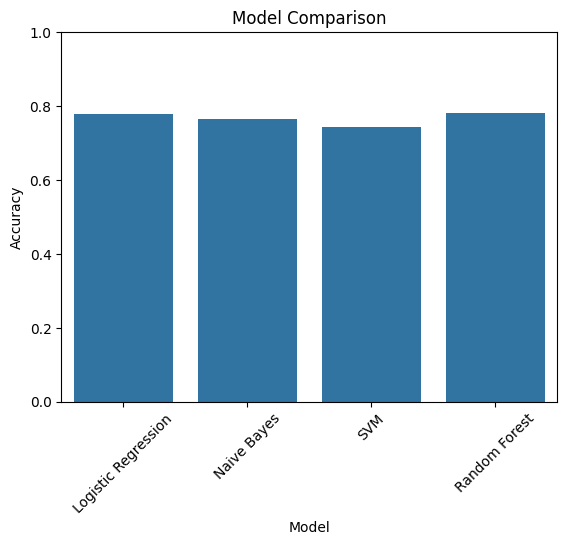

In [36]:
accuracy_df = pd.DataFrame({
    "Model": list(results.keys()),
    "Accuracy": [v["Accuracy"] for v in results.values()]
})
sns.barplot(data=accuracy_df, x="Model", y="Accuracy")
plt.title("Model Comparison")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.show()

In [ ]:
##Grid Search (Hyperparameter Tuning) for One Model

In [37]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10]
}
grid = GridSearchCV(LogisticRegression(), param_grid, cv=3)
grid.fit(X_train_vec, y_train)
print("Best Params:", grid.best_params_)
print("Best Score:", grid.best_score_)

Best Params: {'C': 0.1}
Best Score: 0.771701388888889


In [38]:
final_model = LogisticRegression()
final_model.fit(X_train_vec, y_train)

LogisticRegression()

In [39]:
def predict_sentiment(text, final_model):
    cleaned = preprocess(text)
    vec = vectorizer.transform([cleaned])
    pred = final_model.predict(vec)[0]
    return le.inverse_transform([pred])[0]

In [ ]:
sample_text = "The phone is amazing. Battery life is great and camera is superb!"
print("Predicted Sentiment:", predict_sentiment(sample_text, models['Logistic Regression']))

sample_text = "The phone is terrible. Battery drains quickly and the camera quality is awful!"
print("Predicted Sentiment:", predict_sentiment(sample_text, models['Logistic Regression']))

sample_text = "Worst thing ever. Very disappointed."
print("Predicted Sentiment:", predict_sentiment(sample_text, models['Logistic Regression']))

sample_text = "The food was cold, service was slow, and the waiter was rude. Definitely not coming back."
print("Predicted Sentiment:", predict_sentiment(sample_text, models['Logistic Regression']))

sample_text = "The destination was beautiful, but the hotel was dirty and the staff unhelpful."
print("Predicted Sentiment:", predict_sentiment(sample_text, models['Logistic Regression']))

Predicted Sentiment: Positive
Predicted Sentiment: Negative
Predicted Sentiment: Negative
Predicted Sentiment: Negative
Predicted Sentiment: Positive


In [40]:
print(predict_sentiment("I love this product!", final_model))          # Expected: Positive
print(predict_sentiment("This is the worst ever", final_model))        # Expected: Negative
print(predict_sentiment("It’s fine, nothing special", final_model))    # Expected: Neutral

Positive
Negative
Negative


In [74]:
##Deployment

In [50]:
import joblib

joblib.dump(model, 'sentiment_model.pkl')
joblib.dump(vectorizer, 'vectorizer.pkl')

['vectorizer.pkl']

In [51]:
%%writefile app.py
import streamlit as st
import joblib
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

Writing app.py


In [52]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [54]:
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = str(text).lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalpha() and word not in stop_words]
    return ' '.join(tokens)

In [55]:
model = joblib.load('sentiment_model.pkl')
vectorizer = joblib.load('vectorizer.pkl')

In [68]:
st.title("📝 Sentiment Analysis App")
st.markdown("Enter your review below and get the predicted sentiment.")

2025-07-17 06:23:18.765 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-17 06:23:18.772 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-17 06:23:18.775 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-17 06:23:18.781 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-17 06:23:18.782 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-17 06:23:18.784 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


DeltaGenerator()

In [69]:
input_text = st.text_area("Enter a customer review:")

2025-07-17 06:23:22.955 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-17 06:23:22.957 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-17 06:23:22.958 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-17 06:23:22.959 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-17 06:23:22.960 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-17 06:23:22.960 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-17 06:23:22.961 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [70]:
if st.button("Predict Sentiment"):
    cleaned = preprocess_text(input_text)
    vectorized = vectorizer.transform([cleaned])
    prediction = model.predict(vectorized)[0]
    st.success(f"Predicted Sentiment: **{prediction.upper()}**")

2025-07-17 06:23:24.911 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-17 06:23:24.912 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-17 06:23:24.913 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-17 06:23:24.914 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-17 06:23:24.915 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-17 06:23:24.915 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [71]:
!pip install streamlit pyngrok

In [72]:
from pyngrok import ngrok
# Replace "YOUR_AUTHTOKEN" with your actual ngrok authtoken
ngrok.set_auth_token("YOUR_AUTHTOKEN")

In [73]:
!streamlit run app.py &> /dev/null &